# Comparing the UK's Legislative Agenda to Public Opinion with Visual Analytics

# Introduction
## Background
The “Speech from the Throne” holds an important ceremonial and practical role in the United Kingdom. The monarch addresses her Parliament, outlining the programme for the upcoming session. It reinforces the monarch’s role as Head of State and conveys the governments legislative agenda and focus to the public.
The subjects covered in the Speech range from macroeconomics to minority issues, from employee benefits to waste disposal, and so demonstrate the priorities of the government of the day.

## Motivation
The motivation for this project is to use the Speech from the Throne to analyse how the country has changed over time and to explore the connection between Parliamentary legislation, the policy agenda, and public opinion.

## Data
The data-sets are due to the UK Policy Agendas Project, which lists every Speech from the Throne from 1911, coded by major topic and sub-topic:
-	The Speech from the Throne 1911-2012
-	Acts of UK Parliament 1911-2012
-	Public issue priorities 1960-2014

The Acts of Parliament data-set allows comparison between intention and actual policy. The Public Issue data-set allows an investigation into the extent to which Parliament reflects the public interest.

## Research Questions
The Visual Analytics process is partly led by results, in that it contains a ‘feedback loop’ allowing an iterative process informed by the results of prior analyses (Keim et al., 2010).
I will answer the following research questions, amongst others that may arise from the analysis.
1.	How has the legislative agenda changed over the past century?
2.	Are there some topics which tend to appear together?
3.	To what extent does a Government’s legislative programme reflect the most important issue of the day (as seen by public opinion)?

**Extended research questions

# Analysis

### The Speech from the Throne over Time

First we import the data and apply relevant data cleaning operations, for ease of analysis later.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

#--------------------------------------------------------------
# IMPORT DATA
#--------------------------------------------------------------

# Speech from the Throne data-set
speech = pd.read_excel("Data_Speech_Throne_coded.xls")

# Public Opinion data-set
opinion = pd.read_excel('Data_Public_Opinion.xlsx')

# Acts of Parliament data-set
acts =  pd.read_excel('Data_Acts_Parliament_coded.xls')

In [4]:
#--------------------------------------------------------------
# DATA CLEANING
#--------------------------------------------------------------

# Convert to categorical
variables = ['Policy', 'Major_Topic', 'Sub_Topic', 'Major_Topic_Coded']
for col in variables:
    speech[col] = speech[col].astype('category', copy=False)
    
# Convert to datetime
speech['Date'] = speech['Date'].astype('datetime64[ns]')

Exploratory analysis of the Speech from the Throne

In [7]:
#--------------------------------------------------------------
# VISUAL ANALYTICS
#--------------------------------------------------------------

## Pre-processing and variable initialisation

# Get list of unique major topics
topics = list(speech['Major_Topic_Coded'].unique())
topics.sort()

# Counts by major topic and by year
topic_counts = pd.pivot_table(speech, values='Major_Topic', index=['Year', 'Major_Topic_Coded'], 
                              aggfunc='count', fill_value=0)
topic_counts = topic_counts.reset_index()

## Plot major topic counts overall
topic_counts_by_topic = pd.pivot_table(topic_counts, values='Major_Topic', index='Major_Topic_Coded', aggfunc='sum')
print(topic_counts_by_topic)

                                                    Major_Topic
Major_Topic_Coded                                              
Agriculture                                                 197
Banking, Finance, and Domestic Commerce                     160
Civil Rights, Minority Issues, and Civil Liberties          134
Community Development, Planning and Housing Issues          217
Defence                                                     585
Education                                                   226
Energy                                                       98
Environment                                                  81
Foreign Trade                                               223
Government Operations                                       503
Health                                                      138
International Affairs and Foreign Aid                      1364
Labour and Employment                                       225
Law, Crime, and Family Issues           

We can see that the most common topics are International Affairs and Foreign Aid; Public Lands, Water Management, Colonial and Territorial Issues; Defence; and Macroeconomics, respectively. These relate primarily to foreign policy.

To assess the relative importance of a topic in each year (and therefore changes in topic emphasis over time), we must normalise by the number of topics in each year. In particular, it is hard to see how ‘Space, Science, Technology’ changes over time due to its low frequency. 

The chart below shows that speech length does vary, and increases over time, suggesting a sensible normalisation

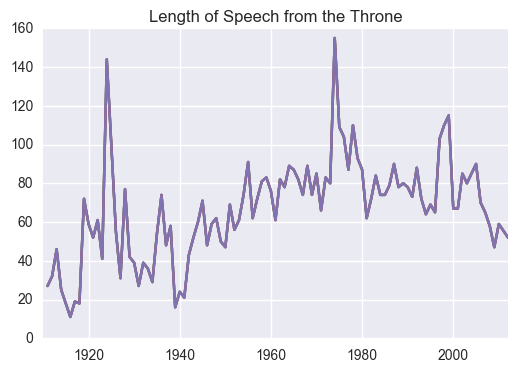

In [12]:
count_by_year = pd.pivot_table(topic_counts, values='Major_Topic', index='Year', aggfunc='sum')
plt.plot(count_by_year)
plt.title('Length of Speech from the Throne')
plt.xlim(1910,2012)
plt.show()

We therefore look at frequency by topic normalised by the total speech length in each year.

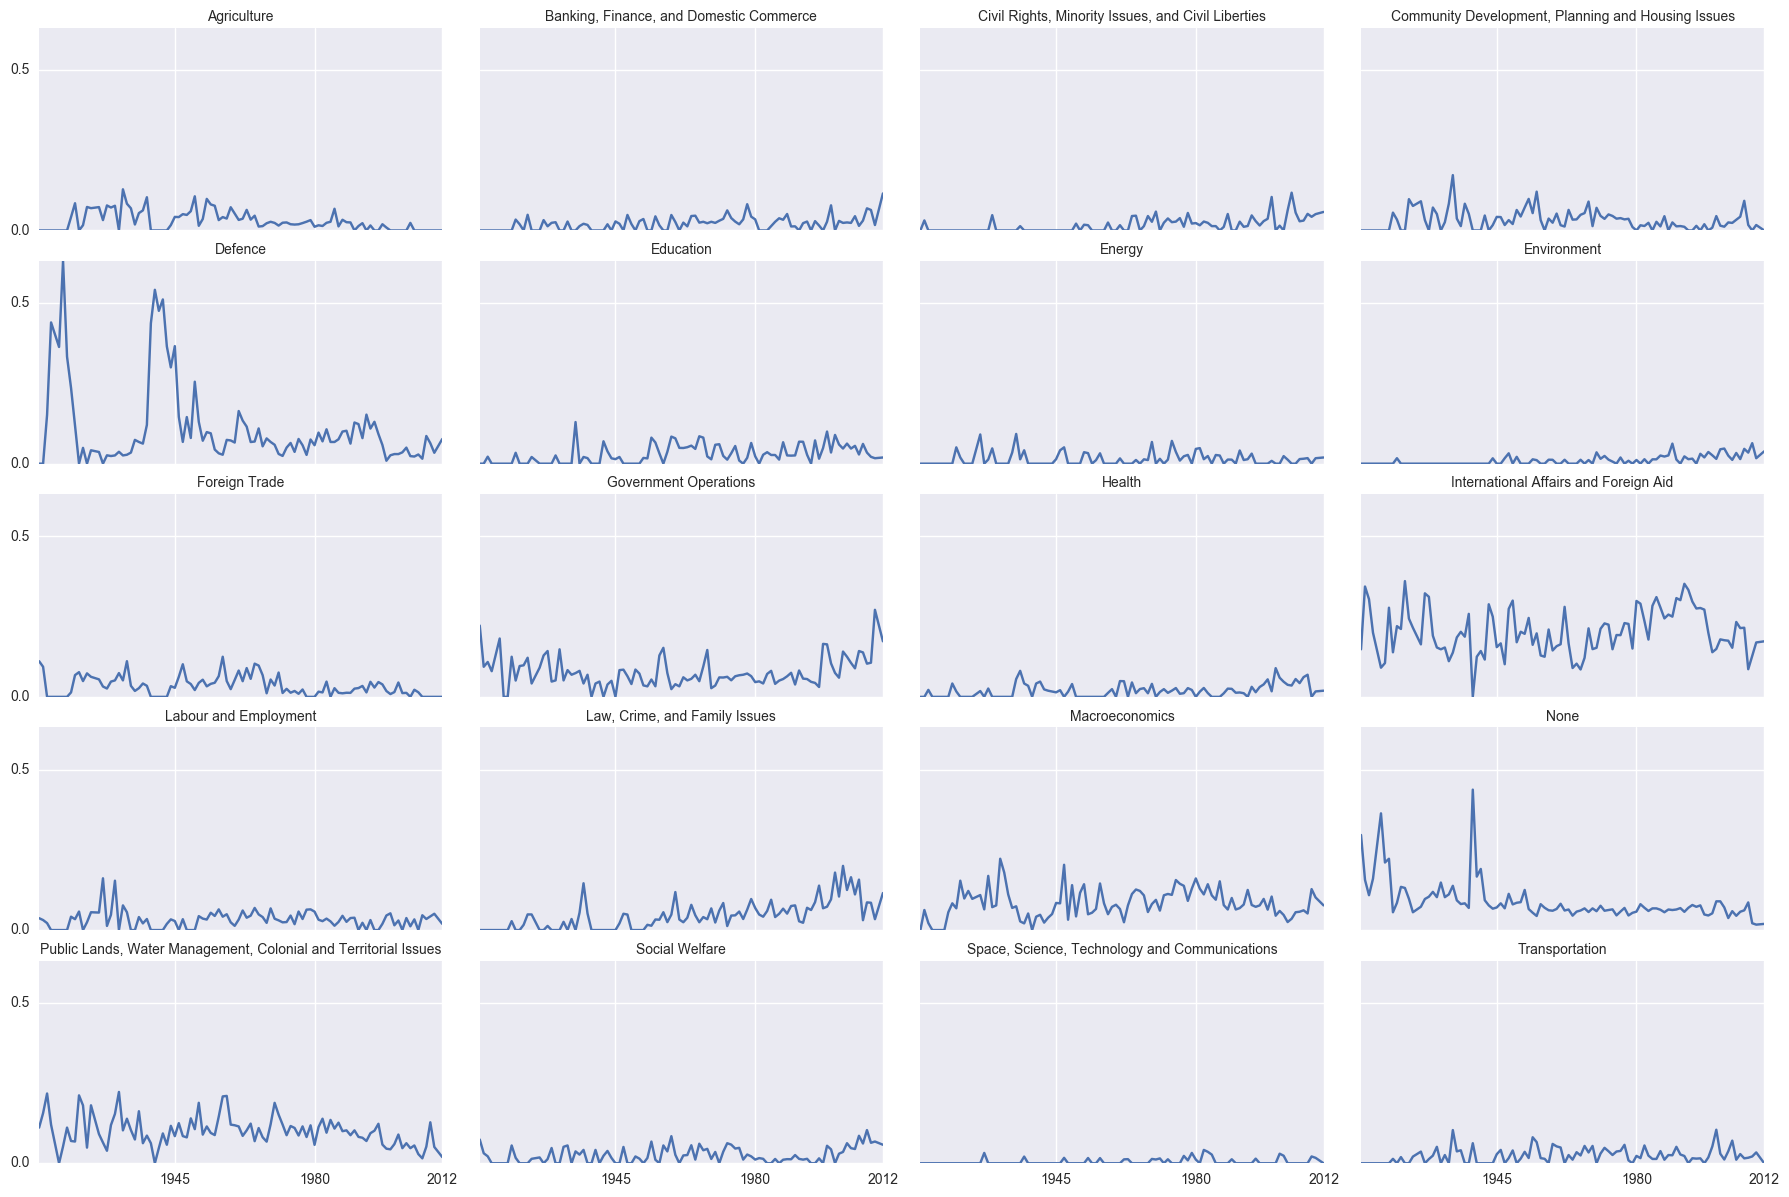

In [13]:
# Prepare subplot indices
plot_index = {}
a = 0
for i in range(0, 5):
    for j in range(0, 4):
        plot_index[a] = (i, j)
        a+=1
        
# Plot major topic counts by year: relative to total counts for each year
topic_counts = topic_counts.merge(count_by_year, left_on='Year', right_index=True)
topic_counts.rename(columns={'Major_Topic_x': 'Counts', 'Major_Topic_y': 'Counts_total_year'}, inplace=True)
topic_counts['Counts_PercentOfYear'] = topic_counts['Counts'] / topic_counts['Counts_total_year']

f2, ax2 = plt.subplots(5,4, sharex='col', sharey='all')
f2.set_size_inches(18, 12)
plt.tight_layout()
plt.rcParams["axes.titlesize"] = 10
plt.setp(ax2, yticks=[0, 0.5, 1.0], xticks=[1910, 1945, 1980, 2012])

count_relative_each_topic = {}

for i in range(0,20):
    count_relative_each_topic[i] = topic_counts[topic_counts['Major_Topic_Coded']==topics[i]]
    ax2[plot_index[i][0], plot_index[i][1]].plot(count_relative_each_topic[i].Year, count_relative_each_topic[i].Counts_PercentOfYear)
    ax2[plot_index[i][0], plot_index[i][1]].set_title(topics[i])

plt.show()

We can see that during the World War years Defence is the dominant topic. 
‘Agriculture’ becomes less important in the second half of the 20th century, whereas ‘Government Operations’, ‘Law, Crime and Family Issues’ are emphasised more. ‘Social welfare’ increases in relative importance from the 1990s onwards, and ‘Defence’ decreases drastically from the mid-1980s. ‘International Affairs and Foreign Aid’ is the dominant topic overall.

Similar conclusions are reached when considering the percentage change in topic importance year-to-year.

We see therefore that the policy agenda as reflected in the Speech from the Throne does change over time: some topics are always prominent, whereas the incidence of others has become (either more, or less) prominent. 

The next question we ask is whether this is due to a change in role of the Speech itself: perhaps its role switches between policy announcements and public relations?

To answer this question I will follow two approaches:
i.	Analyse actual text content of the Speech rather than just topic coding. 
ii.	Analyse the record of Acts of Parliament, to see if the policy agenda is closely linked to that in the Speech from the Throne.

As these approaches are linked to RQ3, where other data-sets will be added to the analysis, I will first look at the relationships between topics in the Speech from the Throne data-set.

Using a dummy variable for each major topic, I chart each variable against the others, using colour hue and shading for correlation strength to allow for a visual analysis of correlation.

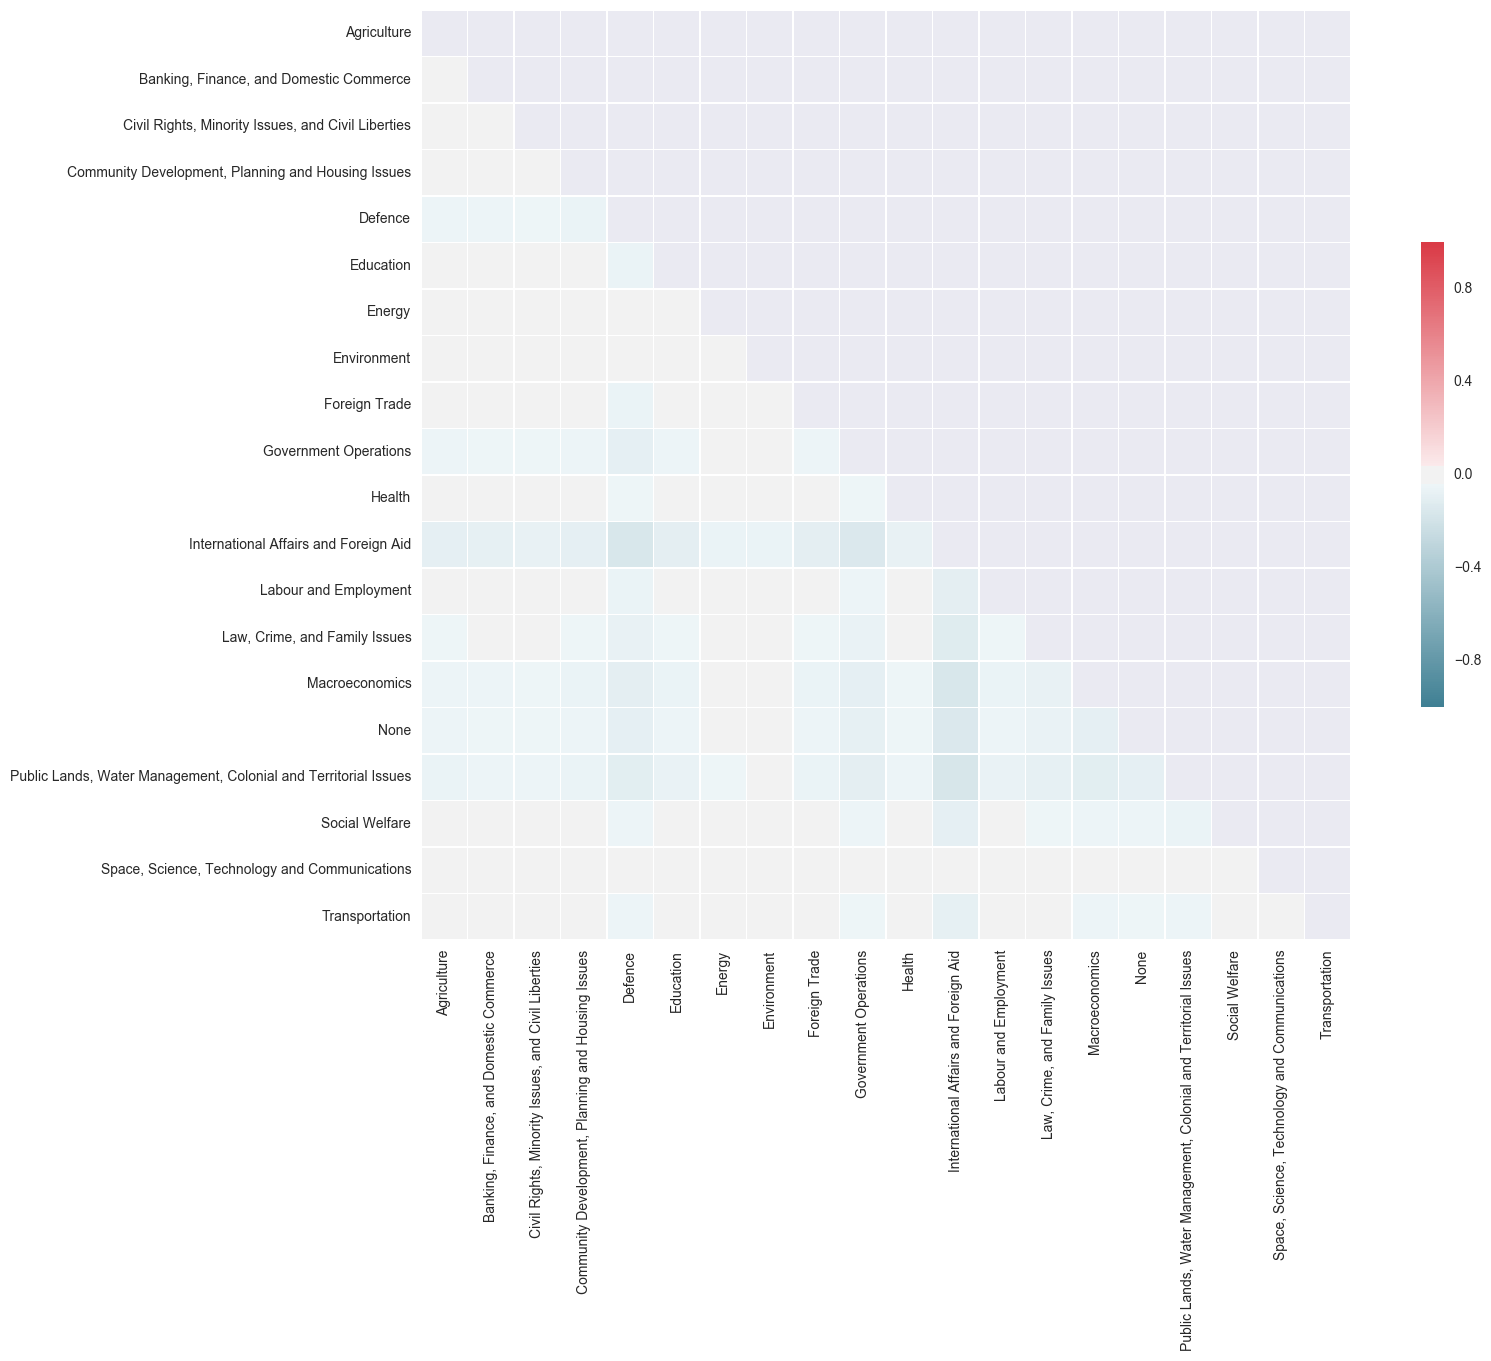

In [16]:
# Calculate correlations within Speech
topic_dummies = pd.get_dummies(speech.Major_Topic_Coded)
correlations = topic_dummies.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(11, 9))
f.set_size_inches(18, 12)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=1, vmin=-1,center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

We can see that the Pearson’s correlation score between variables are weak, and are negative rather than positive. The strongest correlation pairs are Defence / International Affairs & Foreign Aid; International & Foreign Aid / Territorial Issues; and Macroeconomics / International Affairs & Foreign Aid. There may be some insight into the fact that these do not appear together, but it is more likely to be reflective of coding methodology – that separate topics have been successfully identified.

On occasion a promising analysis question does not lead to an interesting result. In this case I decided to move on to the next analysis section.

### The Speech from the Throne in Detail

Although word-clouds can be imprecise, particularly if they contain a large number of ‘stop-words’, they can be effective at imparting a sense of a large body of text. By adding additional politics-related stop-words to the existing Natural Language Processing suite in Python, I produced a word-cloud of Speeches from the Throne for each decade

In [18]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

First we add generic politics-related words to the list of stop-words (such as "It, The, And, etc.")

In [42]:
def stop_words_politics(text):
    # Create list of standard stop words to exclude from the wordcloud
    stop_words = set(stopwords.words('english'))
    # Find additional politics-related stop words, by creating a sorted list of the most 
    # common words (excluding existing stop words)
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    counts = Counter(filtered_sentence)
    common_words = counts.most_common(30)
    stop_words_add = ( x[0] for x in common_words)
    # Add politics-related stop words to the list
    stop_words.update(stop_words_add)
    stop_words.update(['new','also','make','may','co','maintain','support','provision',
                   'policy','system','part','operation','full','brought','seek','give',
                   'proposal','look','introduce','including','Lord','great','must','regard',
                   'early','Bill','general','upon','Government\'s'])
    return stop_words

We generate a wordcloud of Speech from the Throne text for each decade.
Note that the 2010s has only 3 years in the dataset (2010, 2011, 2012).

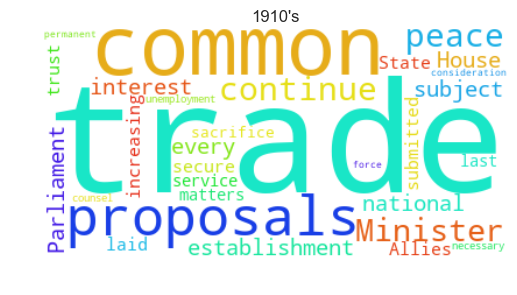

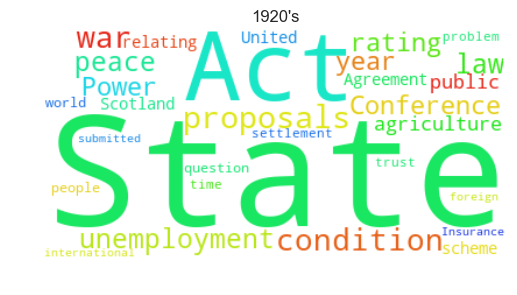

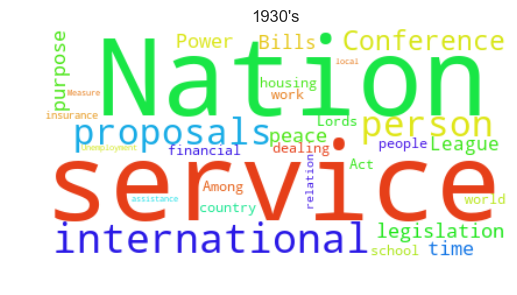

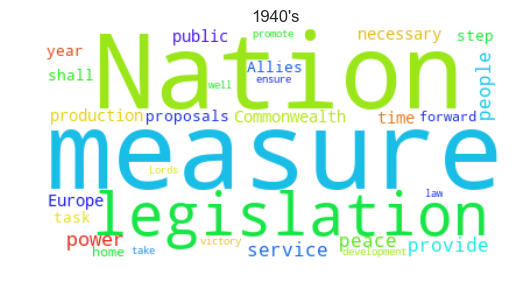

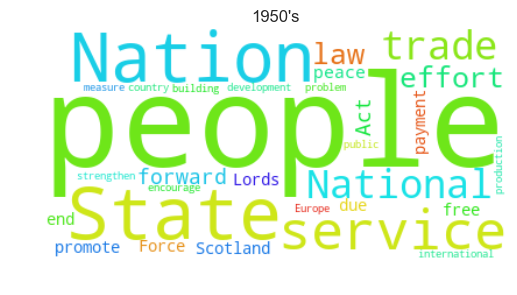

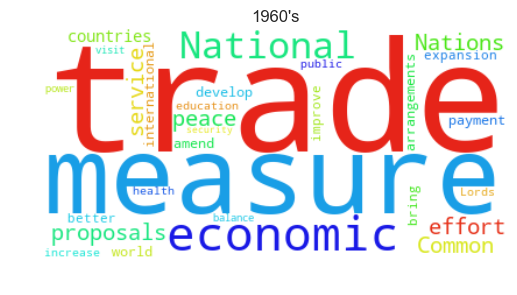

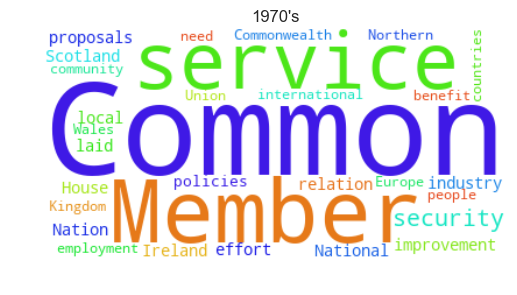

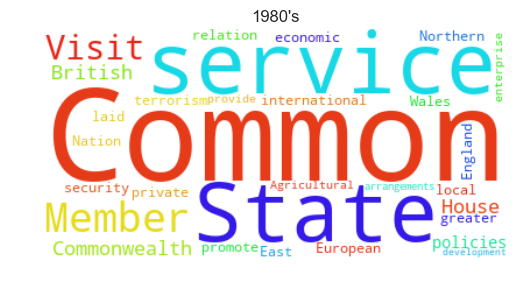

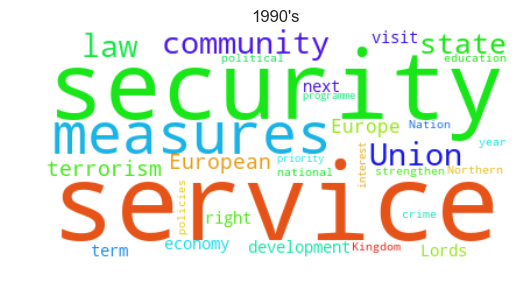

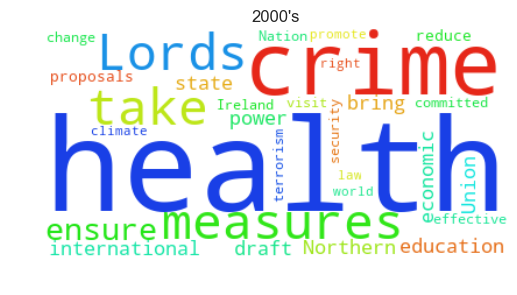

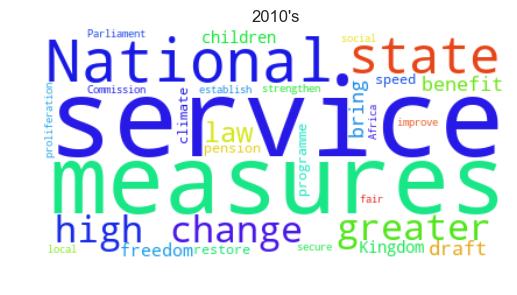

In [43]:
query_years = ['1910','1920','1930','1940','1950','1960','1970','1980','1990','2000','2010']
for query_year in query_years:
    query = str(int(query_year) + 10) + '>Year>=' + query_year
    text = speech.query(query).Text.str.cat(sep='\n')
    stop_words = stop_words_politics(text)
    
    wordcloud = WordCloud(background_color="white", max_words=30, stopwords=stop_words)
    wordcloud.generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(query_year + '\'s')
    filename = 'Wordcloud_' + query_year + '.png'
    plt.show()

We can see that the 1930s and 1940s are concerned with ‘Nation’ and ‘Service’, understandable given the war footing of the country in those years. ‘Common’ becomes more common from the 1950s, reflecting the UK joining the Common Market. In the 2000s and 2010s policy issues are mentioned more in the Speech: crime, health, climate change, children, and pensions making an appearance. 

It seems therefore that the focus of the Speech has changed over time to emphasise policy over public relations, although policy is clearly still present in all Speeches.

Others who've analysed these datasets (Bevan, 2011) have used time series cross-sectional analysis to show that the legislative output closely tracks the policy agenda as outlined in the Speech from the Throne (although the strength of the connection depends on the Party of Government, with a strengthening over time for Conservative governments, and a weakening over time for Labour governments.

We can conclude therefore that the Speech from the Throne is a valid indicator of the policy agenda. Text analysis of the Speech implies that it both sets policy and manages the public’s expectations. 

From the next research question we may be able to confirm this hypothesis: if the Speech from the Throne is less correlated with public opinion than are Acts of Parliament we would have more evidence for the hypothesis that the role of the Speech from the Throne has become more focused on the policy agenda rather than a public relations exercise.

### Public Opinion and the Policy Agenda: adding more data

The creators of these datasets have demonstrated that there is a correspondence between the wishes of the public as represented in ‘most important issue’ polls, and the level of government attention, as per the Speech from the Throne, Acts of Parliament, and Budgetary spending (Jennings, 2011). The level of correspondence for different topics differs. For example, macroeconomics and crime have high levels of correspondence, whereas housing and employment have relatively lower levels of correspondence.

Building on my earlier analysis of topic frequencies, I will use visual analytics techniques to analyse how these correspondences have changed over time, and the interactions between the policy agenda and public opinion

Prepare dataframes for analysis

In [45]:
topic_counts_speech = pd.pivot_table(speech_df, values='Major_Topic', index=['Year', 'Major_Topic_Coded'], 
                              aggfunc='count', fill_value=0)
topic_counts_speech = topic_counts_speech.reset_index()

count_by_year_speech = pd.pivot_table(topic_counts_speech, values='Major_Topic', index='Year', aggfunc='sum')
#count_by_year_speech = count_by_year_speech.to_frame()
topic_counts_speech = topic_counts_speech.merge(count_by_year_speech, left_on='Year', right_index=True)
topic_counts_speech.rename(columns={'Major_Topic_x': 'Counts', 'Major_Topic_y': 'Counts_total_year'}, inplace=True)
topic_counts_speech['Counts_PercentOfYear'] = topic_counts_speech['Counts'] / topic_counts_speech['Counts_total_year']

In [47]:
topic_counts_acts = pd.pivot_table(acts_df, values='Major_Topic', index=['Year', 'Major_Topic_Coded'], 
                              aggfunc='count', fill_value=0)
topic_counts_acts = topic_counts_acts.reset_index()

count_by_year_acts = pd.pivot_table(topic_counts_acts, values='Major_Topic', index='Year', aggfunc='sum')
#count_by_year_acts = count_by_year_acts.to_frame()
topic_counts_acts = topic_counts_acts.merge(count_by_year_acts, left_on='Year', right_index=True)
topic_counts_acts.rename(columns={'Major_Topic_x': 'Counts', 'Major_Topic_y': 'Counts_total_year'}, inplace=True)
topic_counts_acts['Counts_PercentOfYear'] = topic_counts_acts['Counts'] / topic_counts_acts['Counts_total_year']

In [48]:
speech_correspondence = pd.merge(topic_counts_speech, speech_df)
acts_correspondence = pd.merge(topic_counts_acts, acts_df)

Calculate a Pearson’s correlation between the ‘most important issue’ response (reported as a percentage for whom the topic was the most important issue) and the relative frequency of a topic in a given speech year, such that a common scale is available. 

In [49]:
# Correlation between Speech Policy importance and public Opinion for each year
year_correlation_speech = {}
for year in range(1960,2011):
    df = speech_correspondence[speech_correspondence['Year'] == year]
    year_correlation_speech[year] = df['Counts_PercentOfYear'].corr(df['MII_MIP'], method='pearson')

In [50]:
# Correlation between Acts Policy importance and public Opinion for each year
year_correlation_acts = {}
for year in range(1960,2011):
    df = acts_correspondence[acts_correspondence['Year'] == year]
    year_correlation_acts[year] = df['Counts_PercentOfYear'].corr(df['MII_MIP'], method='pearson')

We then plot the correlations between public opinion and the policy agenda, represented by both the Speech from the Throne and Acts of Parliament, for each year, and by topic over the whole period.

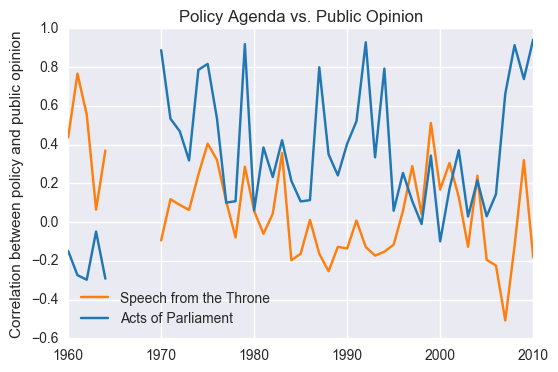

In [52]:
# Plot yearly correlations
plt.plot(*zip(*sorted(year_correlation_speech.items())), color='#ff7f0e')
plt.plot(*zip(*sorted(year_correlation_acts.items())), color='#1f77b4')
plt.title('Policy Agenda vs. Public Opinion')
plt.ylabel('Correlation between policy and public opinion')
plt.legend(['Speech from the Throne', 'Acts of Parliament'], loc='lower left')
plt.show()

We see from the chart that the correspondence between the policy agenda and public opinion is strong, remaining level throughout the years on record for ‘Acts’, and decreasing slightly for the Speech. 

We see also that the correspondence for Acts of Parliament is stronger than for the Speech. 
From this we conclude that Parliament is more reflective of public opinion than the (admittedly rarer) Speech from the Throne. 
We also have more evidence for the hypothesis that the Speech from the Throne has become less of a public relations exercise over time

We repeat the exercise, grouping by topic rather than by year.

In [53]:
topic_correlation_speech = {}
for i in range(0,len(topics)):
    df = speech_correspondence[speech_correspondence['Major_Topic'] == i]
    topic_correlation_speech[topics[i]] = df['Counts_PercentOfYear'].corr(df['MII_MIP'], method='pearson')

# Correlation between Acts Policy importance and Public Opinion for each topic over whole period
topic_correlation_acts = {}
for i in range(0,len(topics)):
    df = acts_correspondence[acts_correspondence['Major_Topic'] == i]
    topic_correlation_acts[topics[i]] = df['Counts_PercentOfYear'].corr(df['MII_MIP'], method='pearson')

In [54]:
# Prepare dataframe with both acts and speech correlations
merged_correls = {}
for key in topic_correlation_acts:
    avg = topic_correlation_acts[key] + topic_correlation_speech[key]
    merged_correls[key] = (topic_correlation_acts[key] , topic_correlation_speech[key], avg)

# Create dataframe from the dictionary
correls_df = pd.DataFrame(merged_correls).transpose()
correls_df = correls_df.sort_values(by=[2], ascending=False)
correls_df.rename(columns={0: 'Acts', 1: 'Speech', 2: 'Average'}, inplace=True)
correls_df.reset_index(inplace=True)

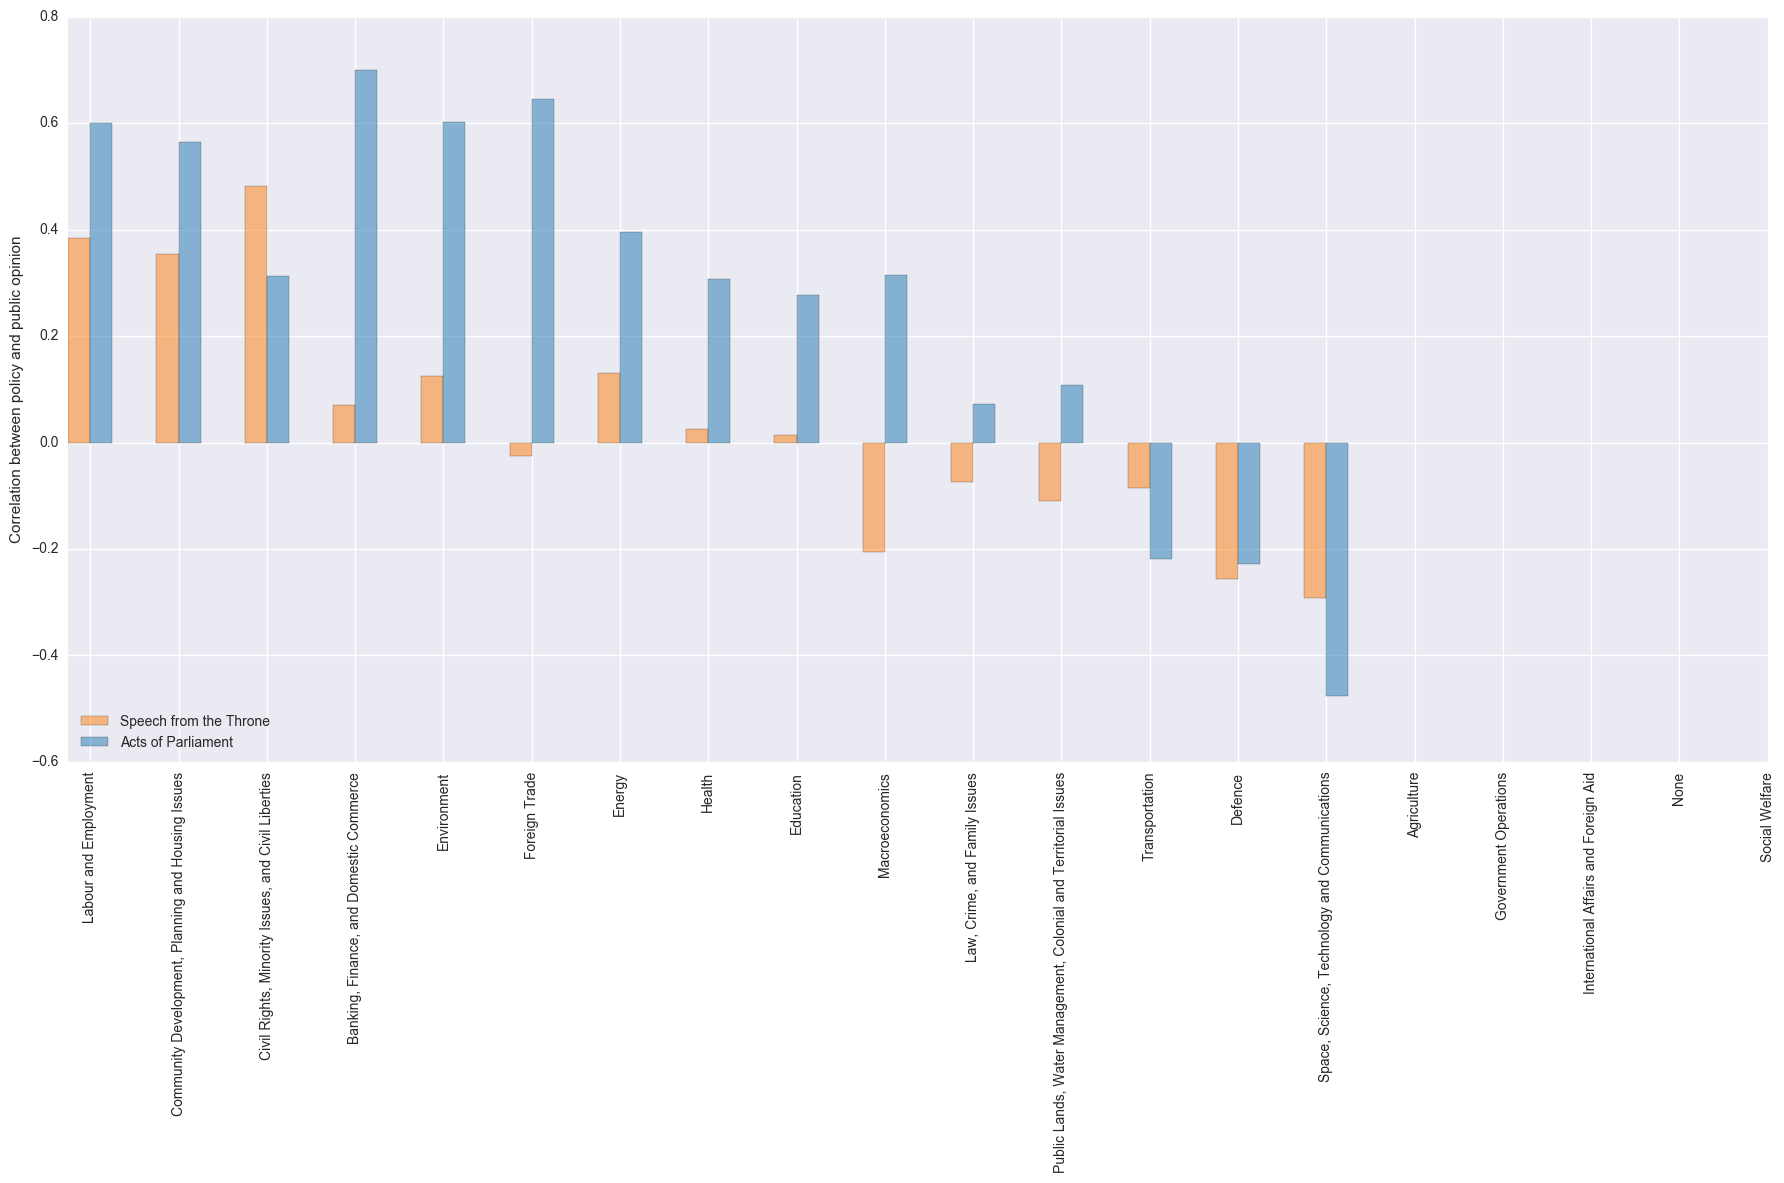

In [55]:
# Plot bar charts
# Setting the positions and width for the bars
pos = list(range(len(correls_df['Acts']))) 
width = 0.25
f, ax = plt.subplots()
f.set_size_inches(18, 12)

# Create a bar with Acts data, in position pos
plt.bar(pos, 
        correls_df['Acts'], 
        # of width
        width,
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#ff7f0e', 
        # with label the first value in first_name
        tick_label=correls_df['index'])

# Create a bar with Speech, in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        correls_df['Speech'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#1f77b4', 
        # with label the second value in first_name
        tick_label=correls_df['index'])

plt.xticks(rotation=90)
plt.ylabel('Correlation between policy and public opinion')
plt.legend(['Speech from the Throne', 'Acts of Parliament'], loc='lower left')
plt.tight_layout()
plt.show()

We see again that the correspondence between Acts of Parliament and public opinion is larger than for the Speech from the Throne, and positive in general. 

There is a *negative* correlation for Education. The largest differences between Acts correlation and Speech correlation are in ‘Government Operations’ and ‘Civil Rights, Minority Issues and Civil Liberties’. The former is understandable, as not much in the topic would need attention in the Speech, but may occupy a large amount of Parliamentary time. The latter would require more investigation.

The final step in this project is to compare the correspondence for each topic over time. As there are a large number of topics, and I would want to compare any number of combination, the most efficient method is to use an interactive analysis tool. 

Using Tableau, I plotted the ‘average policy-opinion difference’ – the absolute difference between the percentage policy importance and the percentage ‘most important issue’ from prior analyses - with an interactive filter allowing choice of any combination of topics. 

Although we can’t use the same Pearson’s correlation in this case, as there is only one data-point for each topic and year, we are still able to observe changes over time.

![Tableau topics over time](/images/tableau example.png)

The above figure shows an example of the interactive tool created with Tableau.

‘Macroeconomics’ has the largest average policy-opinion difference in both the Speech and Acts of Parliament. It is rated the most important issue by 50-80% of the population, yet is only mentioned in the Speech 5-10% of the time. This difference has decreased in the past decade, but remains the topic with the largest difference between policy and public opinion.

## Summary of Findings

The first research aim was to explore how the legislative agenda has changed since 1910. I found that Social Welfare, Law and Crime, and Civil Rights have increased in importance, whereas ‘Territorial and Colonial Issues’, Defence, and Agriculture have decreased in importance. An analysis of the actual text of the Speech from the Throne showed that the emphasis of the Speech also changed: as well as a policy shift as above, the Speech became more policy-focused.

I also asked to what extent the legislative agenda reflects public opinion. In general, the Government’s programme does reflect the most important issues of the day. However, there are differences in how the issues are reflected in policy:

1.	Acts of Parliament more closely reflect public opinion than does the Speech from the Throne.
2.	The Speech from the Throne has become less reflective of public opinion over time, despite it emphasising policy over public relations.
3.	Some policy areas are more closely linked to public opinion: in particular, Law and Crime, Defence, and Civil Rights. Policy related to Education, Macroeconomics, and Transportation does not increase in line with public opinion.


## Critical Evaluation and Further Research

### Evaluation

The goal of this project was to apply visual analytics techniques to answer various research questions related to the Policy Agendas project. The project’s success or failure would be in part dependent on the research questions chosen, as well as the visual analytics techniques used to answer the questions.

The questions relating to the frequency of policy areas in the Speech from the Throne, and the comparison of the policy agenda to public opinion, were both fruitful areas for research.

I was able to discover some interesting patterns, particularly those topics which were previously popular but less so today, and those topics where their legislative progress closely followed public opinion. It was interesting to discover that the emphasis of the Speech from the Throne has recently become more policy-focused, although it remains less correlated to public opinion than do Acts of Parliament.

Visual analytics techniques were useful for this project, as they assist the analyst in guiding his/her research. A visual analytics approach allows a dynamic discovery process, where the results of one piece of analysis can be presented to an analyst, and can therefore be used to plan and complete following analyses. This flexibility was particularly useful to me in this project when looking at policy-opinion correspondence, as I was able to experiment with combinations of topics which gave interesting results, something a conventional, static approach would not allow.
I primarily used simple plots and charts, as these are most easily understood and interpreted. 

For text analysis I used a series of word-clouds. Although word-clouds are imprecise they present a summary of a text in an aesthetically pleasing way. In our case, using word-clouds on text grouped by decade was sufficient to discover evidence to answer our research question. However, word-clouds would be less useful if a deep textual analysis was required.

The *techniques* used were not novel, except perhaps in this domain area. As such the approaches are all generalisable to other domain areas, provided the domain exhibits similar characteristics. For example, correlation heat-maps would not be suitable for a project with multi-dimensional data.

### Further Research

In a further iteration of the project one may wish to explore whether it is policy which affects public opinion or vice versa, and the speed at which this takes place. In other words, how much ‘lag’ is there between when a topic enters the public consciousness and when it is legislated for. Similarly, how soon after its implantation into legislation does the public’s attention dissipate. Time-series analytical techniques would be appropriate here.

Previous research showed that Conservative governments exhibit stronger Speech-to-Acts correspondence than Labour governments.  

An interesting area of research would be to see whether Conservative and Labour governments have different policy emphases. If it were possible to predict the Party of Government from the data, one could also measure a Governments ‘Conservative-ness’, and assess New Labour’s programme on this basis. 
